Adaptive Broadening 'Interpolate' Method

Adaptive Broadening involves convolution with a varying kernel (in this case a Gaussian function with varying sigma) but calculating this exactly is computationally expensive as a Gaussian function must be evaluated for each input point. To speed up the process of adaptive broadening an approximate method can be utilised, where the number of Gaussian kernels that are evaluated are reduced and correspond to only a subset of sigma values. The exact Gaussians that have been computed can then be used to approximate the Gaussians for other values of sigma.

One approach for approximating Gaussians is to use 'morphing' techniques as discussed in Section 4 (check) by (moment morphing paper), some of which give exact solutions. For example a method derived by A.L. Read, allows for a Gaussian function to be determined exactly, no matter how far apart the sigma value for the two input kernels.

<ipython-input-15-acddc9238f94>:30: RuntimeWarning: invalid value encountered in true_divide
  interp = (g1*g2)/(wt1*g2+wt2*g1)


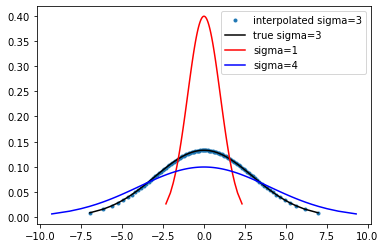

In [15]:
from scipy.special import erfinv

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g

def gaussian_cdfinv(sigma_val, y_range):
    cdf_inv = np.sqrt(2)*sigma_val*erfinv(2*y_range-1)
    return cdf_inv

sigma_min = 1
sigma_max = 4
sigma_interp = 3

y_range = np.linspace(0, 1, 101)
cdf_inv1 = gaussian_cdfinv(sigma_min, y_range)
cdf_inv_interp = gaussian_cdfinv(sigma_interp, y_range)
cdf_inv2 = gaussian_cdfinv(sigma_max, y_range)

wt2 = (sigma_interp-sigma_min)/(sigma_max-sigma_min)
wt1 = 1-wt2

inv_interp = wt1*cdf_inv1 + wt2*cdf_inv2

g1 = gaussian(cdf_inv1, sigma=sigma_min)
g2 = gaussian(cdf_inv2, sigma=sigma_max)

g125 = gaussian(cdf_inv_interp, sigma=sigma_interp)

interp = (g1*g2)/(wt1*g2+wt2*g1)

plt.figure()
plt.plot((wt1*cdf_inv1+wt2*cdf_inv2), interp,'.', label='interpolated sigma=3')
plt.plot(cdf_inv_interp, g125, 'k', label='true sigma=3')
plt.plot(cdf_inv1, g1, 'r', label='sigma=1')
plt.plot(cdf_inv2, g2, 'b', label='sigma=4')
plt.legend()
plt.show()

Therefore with this method, just two Gaussian functions (at the smallest and largest sigma values) would have to be evaluated, and kernels for all other sigma values could be interpolated exactly. However, this approach would still require each input point to be convolved with the interpolated kernel and so is still computationally expensive.

To reduce computation time, a Gaussian can be approximated using a weighted linear combination of two other Gaussians. Rather than using the mixing weights to approximate individual kernels, the weights can be applied to an unbroadened spectrum, scaling it according to the sigma value at each grid point. The spectrum can then be convolved efficiently with only the kernels which have been computed exactly, and the broadened spectrums summed together. Spacing the exact Gaussian kernels regularly over the range of sigma values means that the same weights can be used between each pair of kernels.

The most straightforward way to determine weights for the linear combination is to use linear interpolation, however this does not lead to accurate approximations, particularly when the two input kernels have a wide sigma spacing. Instead of linear interpolation, the weights can be determined using least squares optimization, which reduces the error in the approximations. Below are plots showing results for a sigma spacing of 4, 2 and $\sqrt{2}$. From these plots it is clear that optimised interpolation is consistently more accurate than the linear interpolation, with a smaller RMS Error recorded for each sigma spacing. 


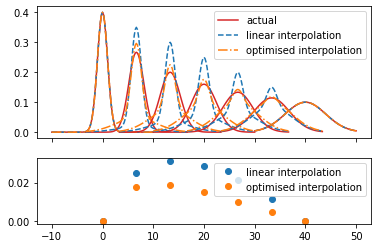

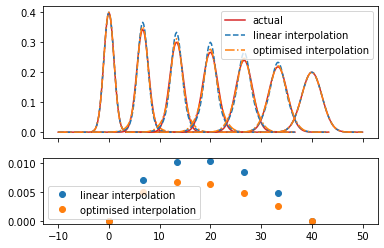

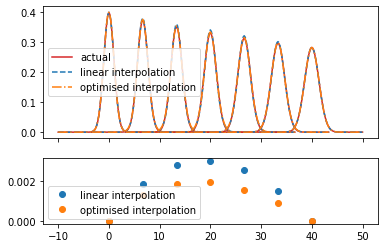

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from collections import OrderedDict

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g

def plot_linear_interp(sigma_max):
    """Plot linearly-interpolated Gaussians"""

    g1_center = 0
    g2_center = 40
    sigma_min = 1

    x = np.linspace(-10, 10, 101)
    npts = 7

    def gaussian_mix(x, w1, w2):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + w2 * gaussian(x, sigma=sigma_max))

    fig, [ax1, ax2] = plt.subplots(nrows=2,
                                        sharex=True,
                                        gridspec_kw={
                                            'height_ratios': [2, 1]})

    for sigma, color in zip(np.linspace(sigma_min, sigma_max, npts),
                            ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']):

        ydata = gaussian(x, sigma=sigma)
        (mix1, mix2), _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5, 0.5])

        x_offset = (g1_center
                  + ((sigma - sigma_min)
                     * (g2_center - g1_center) / (sigma_max - sigma_min)))
        actual = gaussian(x, sigma=sigma)
        low_ref = gaussian(x, sigma=sigma_min)
        high_ref = gaussian(x, sigma=sigma_max)
        mix = (sigma - sigma_min) / (sigma_max - sigma_min)
        est = (1 - mix) * low_ref + mix * high_ref

        est_opt = gaussian_mix(x, mix1, mix2)

        def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

        ax1.plot(x + x_offset, actual, color='C3', label='actual')
        ax1.plot(x + x_offset, est, c='C0', linestyle='--', label='linear interpolation')
        ax1.plot(x + x_offset, est_opt, c='C1', linestyle='-.', label='optimised interpolation')

        legend_without_duplicate_labels(ax1)

        rms = np.sqrt(np.mean((actual - est)**2))
        rms_opt = np.sqrt(np.mean((actual - est_opt)**2))
        ax2.plot([x_offset], [rms], 'o', c='C0',label='linear interpolation')
        ax2.plot([x_offset], [rms_opt], 'o', c='C1', label='optimised interpolation')
        legend_without_duplicate_labels(ax2)

plot_linear_interp(4)
plot_linear_interp(2)
plot_linear_interp(np.sqrt(2))

It is important to understand how to accuracy of the approximation changes with the chosen sigma spacing value. 

A mixture of two Gaussian functions with the same mean but different sigma will always produce a leptokurtic distribution, which compared to a Gaussian distribution has a more prominent peak and fatter tails. A distribution is leptokurtic if its excess kurtosis is positive, with kurtosis being defined as $3\frac{w\sigma_{min}^4 + (1-w)\sigma_{max}^4}{(w\sigma_{min}^2 + (1-w)\sigma_{min}^2)^2} - 3$.
As the sigma spacing decreases, the kurtosis value gets closer to zero, and therefore the distribution produced from the linear combination becomes closer to that of a gaussian distribution.

The change in kurtosis value as the sigma spacing changes can be observed in the below plots, with the top plot showing the change in the approximated Gaussian for a partiular sigma value, and the bottom plot showing the difference between the true Gaussian and approximated Gaussian for each sigma spacing value.

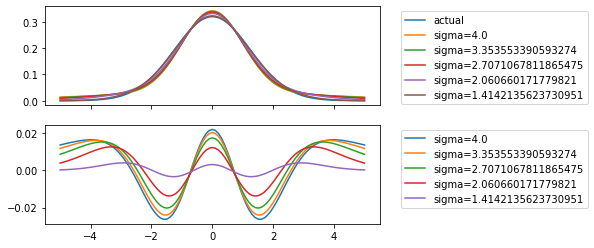

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g

# plot estimated gaussians (sigma=1.25) for various sigma spacing values
sigma_spacing = np.linspace(4,np.sqrt(2),5)
x = np.linspace(-5,5,101)

sigma = 1.25
ydata = gaussian(x, sigma=sigma)

fig, [ax1, ax2] = plt.subplots(nrows=2,
                               sharex=True,
                               gridspec_kw={
                               'height_ratios': [1, 1]})

ax1.plot(x, ydata, label='actual')

sigma_min = 1

for space in sigma_spacing:
    sigma_max = space

    def gaussian_mix(x, w1, w2):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + w2 * gaussian(x, sigma=sigma_max))
    
    (mix1, mix2), _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5, 0.5])
    est = gaussian_mix(x, mix1, mix2)

    diff = (est-ydata)

    ax1.plot(x, est, label='sigma=' + str(space))
    ax2.plot(x, diff, label='sigma=' + str(space))

ax1.legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05,1), loc='upper left')

Plots showing how area between actual and approximated gaussian changes with sigma spacing, and how kurtosis value changes with sigma spacing.

     |████████████████████████████████| 6.2 MB 20.7 MB/s 
     |████████████████████████████████| 532 kB 1.6 MB/s 


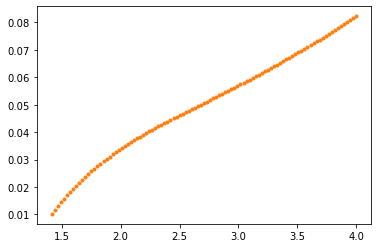

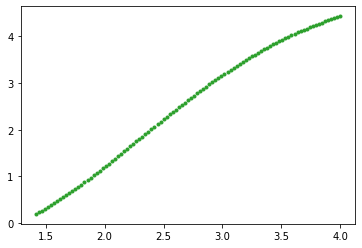

In [7]:
!pip3 install sympy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import *

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g

# plot estimated gaussians (sigma=1.25) for various sigma spacing values
sigma_spacing = np.linspace(4,np.sqrt(2),101)
x = np.linspace(-5,5,101)

sigma = 1.25
ydata = gaussian(x, sigma=sigma)

fig2, ax = plt.subplots()

fig3, ax3 = plt.subplots()

sigma_min = 1

for space in sigma_spacing:
    sigma_max = space

    def gaussian_mix(x, w1, w2):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + w2 * gaussian(x, sigma=sigma_max))
    
    (mix1, mix2), _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5, 0.5])
    est = gaussian_mix(x, mix1, mix2)

    k = 3*(mix1*sigma_min**4+mix2*sigma_max**4)/(mix1*sigma_min**2+mix2*sigma_max**2)**2 - 3

    # find area between actual gaussian and approximation
    w = symbols('w')
    actual_gaussian = exp(-0.5 * (w / sigma)**2) / (sigma * sqrt(2 * pi))
    est_gaussian =  mix1*(exp(-0.5 * (w / sigma_min)**2) / (sigma_min * sqrt(2 * pi)))\
        + mix2*(exp(-0.5 * (w / sigma_max)**2) / (sigma_max * sqrt(2 * pi)))

    test = integrate(actual_gaussian,(w,-oo, oo))

    test2 = integrate(est_gaussian, (w,-oo, oo))

    area = test2-test

    ax.plot([space],[area],'.',color='C1')

    ax3.plot([space],[k],'.',color='C2')

Alogirthm steps - scale data with weights the convolve with upper and lower kernels and add together.
(plot the stages of this to explain)